 <div style="text-align:center;">
  <span style="color:green; font-size:2em; font-weight:bold;">Modélisation</span><br><br>

# <span style="color:green">Introduction</span><br><br> 

### <span style="color:green">Références et équations de base de la relation d'Okun</span><br><br> 

Dans cette partie, nous allons proposer une modélisation permettant de vérifier empiriquement la loi d'Okun, à partir des bases de données établies dans la partie "Préparation_données.ipynb".

La loi d'Okun, indique que : "chaque fois que le PIB chute d'un certain pourcentage, par rapport au produit potentiel, le taux de chômage augmente d'environ un point de pourcentage. Ainsi, lorsque le PIB réel diminue, le taux de chômage augmente." (Mankiw, 2003)

Pour cette modélisation, on s'inspire des travaux suivants : 

- [1]. Traoré, D. L., Diakite, S., & Mariko, O. (2021). Croissance et chômage au Mali : Vérification empirique de la loi d'Okun. Revue Malienne de Science et de Technologie, Série C : Sciences Humaines et Sociales, 02(25), Page. ISSN 1987-1031. CNRST, Bamako, Mali.

- [2]. Aassif, Z. L'extraction de la tendance cycle. Haut-Commissariat au Plan, Direction de la comptabilité nationale. 

- [3]. Belaidi, N. (2022, 28 mars). Validation croisée en Machine Learning. Consulté le  12 décembre 2023. URL : https://blent.ai/blog/a/validation-croisee-machine-learning.


Le travail [1] nous présente deux équations de base de la relation d'Okun, la version en "différences premières" et la "version gap".

- Version en "différences premières" : 
$$\Delta u = C + \beta\Delta \text{pib} + \epsilon$$

- "Version gap" : 
$$u - u^* = c + \beta^*(\text{pib} - \text{pib}^*) + \epsilon$$

avec $u$ le taux de chômage, $u^*$ le taux de chômage naturel, $\text{pib}^*$ le PIB potentiel et c, $\beta$ et $\epsilon$  des constantes à déterminer grâce à la modélisation. 

### <span style="color:green">Equation et outils utilisés dans notre modélisation</span><br><br> 

Pour la modélisation, nous allons utiliser la version "gap", qui relie le taux de chômage et le PIB de la manière suivante : 

$$u - u^* = c + \beta^*(\text{pib} - \text{pib}^*) + \epsilon$$

Pour extraire la tendance à long terme du taux de chômage et du PIB (c'est-à-dire, le taux de chômage naturel et le PIB potentiel), à partir de la base de données, nous allons utiliser le filtre de Hodrick-Prescott. Ce filtre est introduit dans [2], et permet de décomposer une série selon sa tendance à long terme et son cycle (fluctuations autour de la tendance) à plus court terme.

Par ailleurs, pour prendre en compte la dynamique temporelle de nos données, nous allons utiliser le modèle ARDL (Auto Regressive Distributed Lag), introduit dans [2].

### <span style="color:green">Les différentes étapes de notre modélisation</span><br><br> 


Pour effectuer notre modélisation sur les données obtenues suite au traitement, nous allons tout d'abord regrouper les pays présents selon différents critères, grâce à la technique du clustering. 
Nous sélectionnerons un pays de manière aléatoire au sein de chaque groupe afin de vérifier la loi d'Okun (ou alors nous vérifierons la loi d'Okun pour chaque groupe après agrégation).

(Par ailleurs, nous allons utiliser une méthode de validation croisée afin de valider notre modèle. Nous allons tout d'abord établir les paramètres du modèle grâce au jeu d'entrainement reprenant les données de 1994 à 2016 ; puis nous vérifierons la précision du modèle grâce au jeu de test reprenant les données de 2017 à 2023.


# <span style="color:green"> I- Extraction de la tendance à long terme du taux de chômage et du PIB</span><br><br> 

## <span style="color:green"> Importation des bases de données</span><br><br> 

In [12]:
# Importation des packages
import declarations as d 

In [13]:
# Base de données obtenue suite au nettoyage
data = d.pd.read_csv('bases/final_data.csv', encoding='latin-1')

In [14]:
# Visualisation
data.head(2)

,YEAR,COUNTRY,Unemployment_rate,GDP_rate,life_expentancy,pop_growth_rate
0,1994-01,AUS,9.814137,0.501645,77.878049,0.963092
1,1994-01,SVN,14.650000,0.748256,73.404878,-0.115694


### <span style="color:green"> Base de données pour la modélisation des séries temporelles </span><br><br> 

Pour la modélisation des séries temporelles modélisant la relation entre le PIB et le taux de chômage, nous avons besoin de ces variables pour chaque pays en colonnes et de la date en indice. 

In [15]:
# Utilisation de la fonction pivot pour remodeler le dataframe
df_pivot = data.pivot(index=['YEAR'], columns='COUNTRY',
                    values=['Unemployment_rate', 'GDP_rate'])

# Ajuster les noms de colonnes
df_pivot.columns = [f'{col[1]}_{col[0].lower()}' for col in df_pivot.columns]

# Réinitialiser l'index pour avoir les colonnes YEAR et MONTH comme des colonnes régulières
df_pivot.reset_index(inplace=True)

# Afficher le nouveau dataframe
df_pivot.head(2)


,YEAR,AUS_unemployment_rate,AUT_unemployment_rate,BEL_unemployment_rate,BGR_unemployment_rate,CAN_unemployment_rate,CHE_unemployment_rate,CZE_unemployment_rate,DEU_unemployment_rate,ESP_unemployment_rate,...,POL_gdp_rate,PRT_gdp_rate,ROU_gdp_rate,RUS_gdp_rate,SGP_gdp_rate,SVK_gdp_rate,SVN_gdp_rate,SWE_gdp_rate,URY_gdp_rate,USA_gdp_rate
0,1994-01,9.814137,6.609708,9.641018,14.300000,10.700000,4.704339,4.3,7.261003,22.000000,...,0.744291,0.753611,1.405948,0.131693,0.806523,0.781847,0.748256,0.585296,NaN,0.650468
1,1994-02,10.269157,6.582263,9.728535,15.393333,10.866667,4.839299,4.2,7.521107,22.233333,...,0.745930,0.757949,1.443999,0.134277,0.812181,0.773778,0.754609,0.587775,NaN,0.653595


In [16]:
df_pivot = df_pivot.rename(columns=lambda x: x.replace('_rate', ''))
df_pivot.head(2)

,YEAR,AUS_unemployment,AUT_unemployment,BEL_unemployment,BGR_unemployment,CAN_unemployment,CHE_unemployment,CZE_unemployment,DEU_unemployment,ESP_unemployment,...,POL_gdp,PRT_gdp,ROU_gdp,RUS_gdp,SGP_gdp,SVK_gdp,SVN_gdp,SWE_gdp,URY_gdp,USA_gdp
0,1994-01,9.814137,6.609708,9.641018,14.300000,10.700000,4.704339,4.3,7.261003,22.000000,...,0.744291,0.753611,1.405948,0.131693,0.806523,0.781847,0.748256,0.585296,NaN,0.650468
1,1994-02,10.269157,6.582263,9.728535,15.393333,10.866667,4.839299,4.2,7.521107,22.233333,...,0.745930,0.757949,1.443999,0.134277,0.812181,0.773778,0.754609,0.587775,NaN,0.653595


### <span style="color:green"> Base de données pour le clustering </span><br><br> 

Pour le clustering, nous avons besoin d'une base de données avec en indice le nom des pays et en colonnes, les différents critères considérés, moyennés sur la période considérée.

In [17]:
# Utilisation de la fonction pivot pour remodeler le dataframe
df_cluster = data.pivot_table(index='COUNTRY', values=['Unemployment_rate', 'GDP_rate','life_expentancy',
       'pop_growth_rate'], aggfunc='mean')

df_cluster.head(2)

,GDP_rate,Unemployment_rate,life_expentancy,pop_growth_rate
COUNTRY,,,,
AUS,0.761392,6.027355,80.916318,1.342107
AUT,0.899732,7.236287,79.720527,0.449969


## <span style="color:green">Extraction de la tendance à long terme pour le taux de chômage (unemployement)</span><br><br> 

In [18]:
# Extraire toutes les colonnes avec le suffixe "_rate" ainsi que la colonne des dates
columns_unemployment = ['YEAR'] + [col for col in df_pivot.columns if col.endswith('_unemployment')] 
df_unemployment = df_pivot[columns_unemployment]
df_unemployment.set_index('YEAR', inplace = True)

df_unemployment.head(2)

,AUS_unemployment,AUT_unemployment,BEL_unemployment,BGR_unemployment,CAN_unemployment,CHE_unemployment,CZE_unemployment,DEU_unemployment,ESP_unemployment,EST_unemployment,...,POL_unemployment,PRT_unemployment,ROU_unemployment,RUS_unemployment,SGP_unemployment,SVK_unemployment,SVN_unemployment,SWE_unemployment,URY_unemployment,USA_unemployment
YEAR,,,,,,,,,,,,,,,,,,,,,
1994-01,9.814137,6.609708,9.641018,14.300000,10.700000,4.704339,4.3,7.261003,22.000000,7.600000,...,16.450000,7.756329,10.9,6.759498,1.750000,14.620000,14.650000,10.839335,12.100000,6.2
1994-02,10.269157,6.582263,9.728535,15.393333,10.866667,4.839299,4.2,7.521107,22.233333,7.466667,...,16.533333,7.916827,10.9,6.574419,1.666667,14.426667,14.966667,10.866990,12.083333,6.5


## <span style="color:green">Extraction de la tendance à long terme pour le PIB (gdp)</span><br><br> 

In [19]:
# Extraire toutes les colonnes avec le suffixe "_gdp" ainsi que la colonne des dates
columns_gdp = ['YEAR'] + [col for col in df_pivot.columns if col.endswith('_gdp')] 
df_gdp = df_pivot[columns_gdp]
df_gdp.set_index('YEAR', inplace = True)

df_gdp.head(2)

,AUS_gdp,AUT_gdp,BEL_gdp,BGR_gdp,CAN_gdp,CHE_gdp,CZE_gdp,DEU_gdp,ESP_gdp,EST_gdp,...,POL_gdp,PRT_gdp,ROU_gdp,RUS_gdp,SGP_gdp,SVK_gdp,SVN_gdp,SWE_gdp,URY_gdp,USA_gdp
YEAR,,,,,,,,,,,,,,,,,,,,,
1994-01,0.501645,0.779464,0.796550,0.559233,0.680429,0.907331,0.814153,0.794548,0.774291,0.525902,...,0.744291,0.753611,1.405948,0.131693,0.806523,0.781847,0.748256,0.585296,NaN,0.650468
1994-02,0.502208,0.783616,0.798246,0.559740,0.680180,0.909250,0.818056,0.796374,0.778426,0.534253,...,0.745930,0.757949,1.443999,0.134277,0.812181,0.773778,0.754609,0.587775,NaN,0.653595


# <span style="color:green"> II- Clustering : regroupement des pays selon des critères de développement</span><br><br> 

Dans cette partie, on va utiliser la méthode du clustering pour regrouper les pays de la base de données selon 4 critères : 
<div style="margin-left: 20px;">
    <span style="font-weight:bold;">1.</span> Le PIB,<br>
    <span style="font-weight:bold;">2.</span> Le taux de chômage,<br>
    <span style="font-weight:bold;">3.</span> L'espérance de vie,<br>
    <span style="font-weight:bold;">4.</span> et le taux de croissance démographique.
    </div><br>
    Chaque variable moyennée sur la période considérée. 


In [20]:
# Supprimer les lignes ayant des valeurs manquantes
df_cluster.dropna(inplace=True)
df_cluster.head()

,GDP_rate,Unemployment_rate,life_expentancy,pop_growth_rate
COUNTRY,,,,
AUS,0.761392,6.027355,80.916318,1.342107
AUT,0.899732,7.236287,79.720527,0.449969
BEL,0.913237,7.774560,79.483950,0.498965
BGR,0.799515,10.575434,72.878191,-0.792854
CAN,0.922738,7.485185,80.470733,1.032642


In [21]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: C:\Users\yousr\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


C:\Users\yousr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


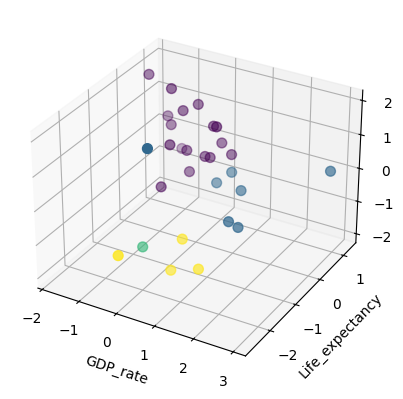

In [22]:
# Standardiser les données (important pour K-means)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_cluster)

# Appliquer l'algorithme K-means
num_clusters = 4  # Choisissez le nombre de clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df_cluster['Cluster'] = kmeans.fit_predict(df_scaled)

# Visualisation en 3D (utilisant les variables GDP_rate, Life_expectance, Pop_growth_rate)
fig = d.plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_scaled[:, 1], df_scaled[:, 2], df_scaled[:, 3], c=df_cluster['Cluster'], cmap='viridis', s=50)
ax.set_xlabel('GDP_rate')
ax.set_ylabel('Life_expectancy')
ax.set_zlabel('Pop_growth_rate')
d.plt.show()

In [23]:
# Afficher les groupes et les pays
for cluster_num in range(num_clusters):
    countries_in_cluster = df_cluster[df_cluster['Cluster'] == cluster_num].index
    print(f'Cluster {cluster_num + 1}: {list(countries_in_cluster)}')

Cluster 1: ['AUS', 'AUT', 'BEL', 'CAN', 'CHE', 'CZE', 'DEU', 'FRA', 'GBR', 'IRL', 'JPN', 'LUX', 'NOR', 'NZL', 'SGP', 'SWE', 'USA']
Cluster 2: ['ESP', 'FIN', 'PHL', 'POL', 'PRT', 'SVK', 'SVN']
Cluster 3: ['ROU']
Cluster 4: ['BGR', 'EST', 'LTU', 'RUS']


# <span style="color:green"> III- Vérification de la loi pour un pays tiré aléatoirement dans chaque groupe</span><br><br> 

## Modélisation de la relation entre PIB et taux de chômage, pour un pays donné, grâce au modèle ARDL 

### Extraction de la tendance à long terme du PIB et du taux de chômage d'un pays.

Dans cette partie, on définit une classe qui permet de tracer la tendance à long terme et les cycles à court terme des deux variables considérées. 

La méthode df_gap() de cette classe permet d'obtenir une série avec les valeurs de la différence entre la valeur réelle et la tendance à long terme des deux variables considérées, pour un pays considéré. 

In [24]:
class CountryData:
    def __init__(self, country_code, unemployment_data, gdp_data):
        """
        Initialize a CountryData instance.

        Parameters:
        - country_code (str): The country code.
        - unemployment_data (pd.Series): Time series data for unemployment rate.
        - gdp_data (pd.Series): Time series data for GDP rate.
        """
        
        self.country_code = country_code
        self.unemployment_rate = unemployment_data[f'{country_code}_unemployment']
        self.gdp_rate = gdp_data[f'{country_code}_gdp']

    def plot_trend_cycle(self):
        """
        Plot the trend and cycle components for unemployment rate and GDP rate after applying the Hodrick-Prescott filter to the time series.
        """
        # Extraction of the long-term trend of unemployment rate
        x = self.unemployment_rate

        # Applying the Hodrick-Prescott filter
        trend_x, cycle_x = d.smf.hpfilter(x, lamb=1600)

        # Plot the trend and cycle of unemployment rate
        d.plt.plot(x, label='Original series')
        d.plt.plot(trend_x, label='Trend')
        d.plt.plot(cycle_x, label='Cycle')
        d.plt.legend()
        d.plt.show()

        # Extraction of the long-term trend of GDP
        y = self.gdp_rate

        # Applying the Hodrick-Prescott filter
        trend_y, cycle_y = d.smf.hpfilter(y, lamb=1600)

        # Plot the trend and cycle of the trend
        d.plt.plot(y, label='Originale series')
        d.plt.plot(trend_y, label='Trend')
        d.plt.plot(cycle_y, label='Cycle')
        d.plt.legend()
        d.plt.show()
        
    def df_gap(self):
        """
        Calculate the gap series for unemployment rate and GDP rate.

        Returns:
        - df_gap (pd.DataFrame): DataFrame containing the gap values.
        """
        # Extraction of the long-term trend of unemployment rate
        x = self.unemployment_rate

        # Applying the Hodrick-Prescott filter
        trend_x, cycle_x = d.smf.hpfilter(x, lamb=1600)
    
        # Extraction of the long-term trend of GDP
        y = self.gdp_rate

        # Applying the Hodrick-Prescott filter
        trend_y, cycle_y = d.smf.hpfilter(y, lamb=1600)
    
        # Calculate the new series by removing the trend
        gap_unemployment = x - trend_x
        gap_gdp = y - trend_y

        # Create a DataFrame with the new series
        df_x = d.pd.DataFrame({'YEAR': x.index, 'gap_unemployment': gap_unemployment.values})
        df_y = d.pd.DataFrame({'YEAR': y.index, 'gap_gdp': gap_gdp.values})

        # Merge the DataFrames on the 'YEAR' column
        df_gap = d.pd.merge(df_x, df_y, on='YEAR', how='inner')

        return df_gap


### Modèle ARDL

In [25]:
from statsmodels.tsa.stattools import adfuller

In [26]:
belgium = CountryData('BEL', df_unemployment, df_gdp)

In [27]:
belgium.df_gap()

,YEAR,gap_unemployment,gap_gdp
0,1994-01,10.017243,0.771871
1,1994-02,9.962364,0.769040
2,1994-03,9.907249,0.766225
3,1994-04,9.851518,0.763459
4,1995-01,9.794773,0.760797
...,...,...,...
112,2022-01,5.609398,1.161251
113,2022-02,5.578970,1.170971
114,2022-03,5.548911,1.180789
115,2022-04,5.519036,1.190660


In [28]:
unemployment_series = belgium.df_gap()['gap_unemployment']
gdp_series = belgium.df_gap()['gap_gdp']

Vérifions tout d'abord la stationnarité de la série

In [29]:
# Fonction pour effectuer le test ADF et imprimer les résultats
def perform_adf_test(series, name):
    result = adfuller(series, autolag='AIC')
    print(f'Test ADF pour la série {name}:')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Nombre de lags utilisés: {result[2]}')
    print(f'Nombre d\'observations utilisées: {result[3]}')
    print(f'Valeurs critiques:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

# Appliquer le test ADF pour le taux de chômage et le PIB réel
perform_adf_test(unemployment_series, 'Unemployment_rate')
perform_adf_test(gdp_series, 'Real_GDP')

Test ADF pour la série Unemployment_rate:
ADF Statistic: -0.5396196618647554
p-value: 0.8840503707945941
Nombre de lags utilisés: 5
Nombre d'observations utilisées: 111
Valeurs critiques:
   1%: -3.490683082754047
   5%: -2.8879516565798817
   10%: -2.5808574442009578
Test ADF pour la série Real_GDP:
ADF Statistic: 3.2087182411369555
p-value: 1.0
Nombre de lags utilisés: 6
Nombre d'observations utilisées: 110
Valeurs critiques:
   1%: -3.4912451337340342
   5%: -2.8881954545454547
   10%: -2.5809876033057852


Des p-values de 0.8840503707945941 et de 1.0 indiquent que nous ne pouvons pas rejeter l'hypothèse nulle selon laquelle les séries ne sont pas stationnaires. En d'autres termes, cela suggère que les séries ne sont pas stationnaires.

Pour rendre nos séries stationnaires, nous pouvons envisager de les différencier. La différenciation consiste à soustraire chaque observation de l'observation précédente. nous pouvons utiliser la fonction diff() de pandas pour effectuer cette opération. Voici comment nous pouvons le faire :

In [30]:
# Différenciation des séries temporelles
diff_unemployment_series = unemployment_series.diff().dropna()
diff_gdp_series = gdp_series.diff().dropna()

# Réappliquer le test ADF aux séries différenciées
perform_adf_test(diff_unemployment_series, 'Diff_Unemployment_rate')
perform_adf_test(diff_gdp_series, 'Diff_Real_GDP')


Test ADF pour la série Diff_Unemployment_rate:
ADF Statistic: -2.3339550976499437
p-value: 0.16125046714001406
Nombre de lags utilisés: 4
Nombre d'observations utilisées: 111
Valeurs critiques:
   1%: -3.490683082754047
   5%: -2.8879516565798817
   10%: -2.5808574442009578
Test ADF pour la série Diff_Real_GDP:
ADF Statistic: -0.34016888377020005
p-value: 0.9196193991811563
Nombre de lags utilisés: 3
Nombre d'observations utilisées: 112
Valeurs critiques:
   1%: -3.4901313156261384
   5%: -2.8877122815688776
   10%: -2.5807296460459184


Les valeurs des p-values sont toujours trop élevées pour les deux séries et ne permettent pas de rejeter l'hypothèse nulle. 

Cela suggère que même après la première différenciation, les séries nen sont pas encore stationnaire.
Nous pouvons envisager d'effectuer une différenciation supplémentaire pour voir si cela améliore la stationnarité des séries.

In [31]:
# Deuxième différenciation pour Diff_Unemployment_series
diff2_unemployment_series = diff_unemployment_series.diff().dropna()

# Deuxième différenciation pour Diff_Real_GDP
diff2_gdp_series = diff_gdp_series.diff().dropna()

# Test ADF pour la deuxième différenciation
perform_adf_test(diff2_unemployment_series, 'Diff2_Unemployment_Series')
# Test ADF pour la deuxième différenciation
perform_adf_test(diff2_gdp_series, 'Diff2_Real_GDP')

Test ADF pour la série Diff2_Unemployment_Series:
ADF Statistic: -3.478648646023418
p-value: 0.008552675518290713
Nombre de lags utilisés: 2
Nombre d'observations utilisées: 112
Valeurs critiques:
   1%: -3.4901313156261384
   5%: -2.8877122815688776
   10%: -2.5807296460459184
Test ADF pour la série Diff2_Real_GDP:
ADF Statistic: -2.819753522190142
p-value: 0.05550704772181252
Nombre de lags utilisés: 2
Nombre d'observations utilisées: 112
Valeurs critiques:
   1%: -3.4901313156261384
   5%: -2.8877122815688776
   10%: -2.5807296460459184


Les valeurs des p-values pour la deuxième différenciation des deux séries sont faibles. Cela suggère que, après la deuxième différenciation, nous pouvons rejeter l'hypothèse nulle selon laquelle chaque série n'est pas stationnaire. Par conséquent, les deux sérries obtenues après deux différentiations semblent être stationnaires.

Cela est une bonne nouvelle car la stationnarité est une condition importante pour l'application de modèles ARDL. À ce stade, nous pouvons utiliser les séries temporelles différenciées (2 fois) dans notre modèle ARDL pour étudier la relation entre le taux de chômage et le PIB. 

Par ailleurs, il faut également prendre en compte le nombre approprié de retards (lags) pour chaque variable afin de spécifier correctement notre modèle.
Pour déterminer le nombre optimal de retards (lags) dans un modèle ARDL, nous pouvons utiliser des graphiques de la fonction d'autocorrélation (ACF) et de la fonction d'autocorrélation partielle (PACF). Ces graphiques peuvent nous aider à identifier les retards significatifs qui affectent la série temporelle.
Ces graphiques aident à visualiser les corrélations entre les observations à différents retards. Nous devons rechercher des retards significatifs où les corrélations sont en dehors de l'intervalle de confiance.

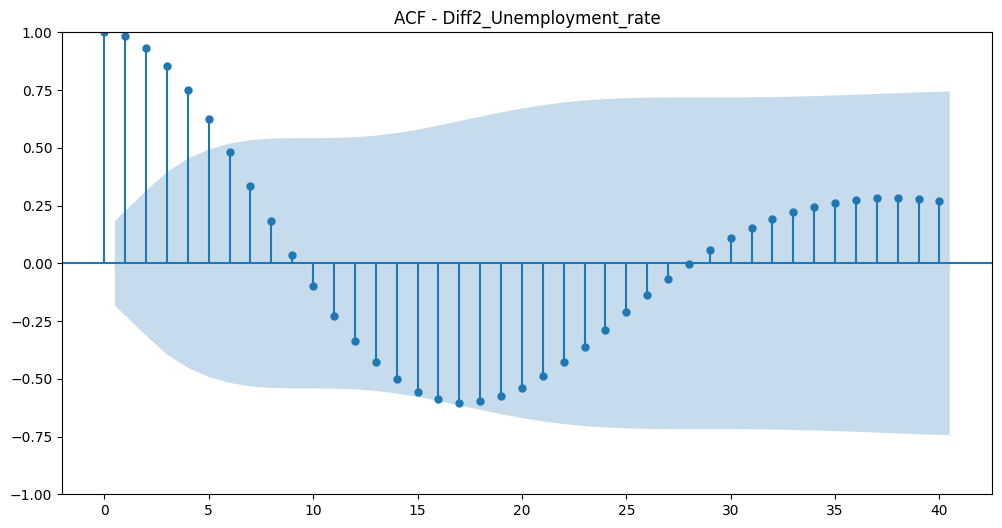

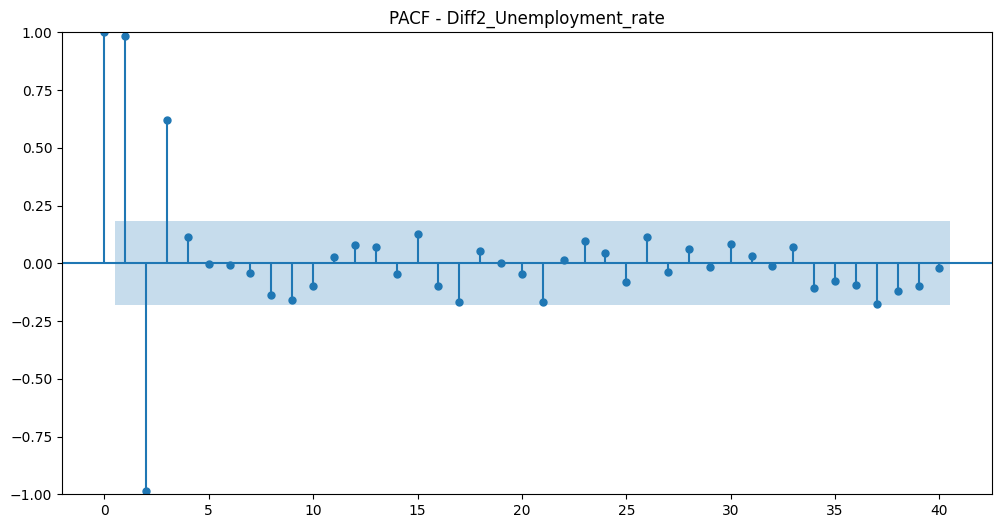

In [32]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Supposons que df_diff soit votre DataFrame avec les séries temporelles différenciées
# Vous pouvez remplacer 'Diff_Unemployment_rate' et 'Diff_Real_GDP' par les noms réels de vos colonnes.
df_diff = d.pd.DataFrame({
    'Diff2_Unemployment_rate': diff2_unemployment_series,
    'Diff2_Real_GDP': diff2_gdp_series
})

# Tracez les fonctions d'autocorrélation (ACF) et d'autocorrélation partielle (PACF)
fig, ax = d.plt.subplots(figsize=(12, 6))

# ACF
plot_acf(df_diff['Diff2_Unemployment_rate'], ax=ax, lags=40, title='ACF - Diff2_Unemployment_rate')
d.plt.show()

# PACF
fig, ax = d.plt.subplots(figsize=(12, 6))
plot_pacf(df_diff['Diff2_Unemployment_rate'], ax=ax, lags=40, title='PACF - Diff2_Unemployment_rate')
d.plt.show()


Si le premier pic dans la fonction d'autocorrélation (ACF) est très élevé et significatif, et qu'il est en dehors de l'intervalle de confiance, cela suggère qu'un seul retard (lag = 1) pourrait être suffisant pour capturer l'autocorrélation significative dans nos données.

Choisir un seul retard peut également simplifier notre modèle ARDL et le rendre plus interprétable. 

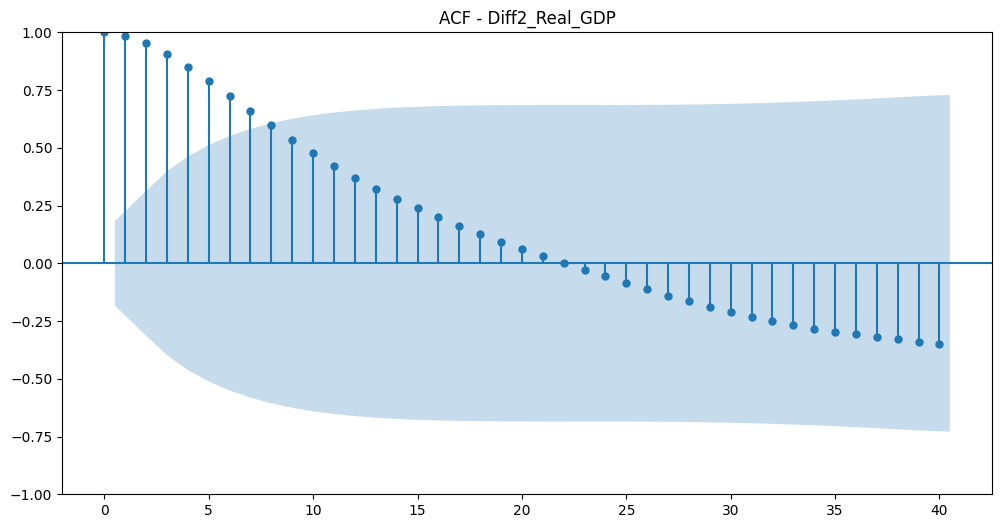

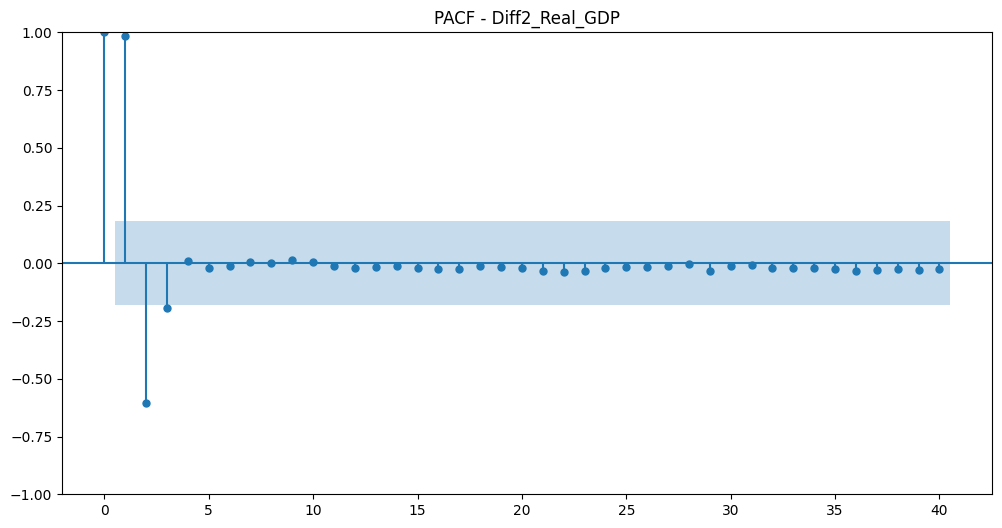

In [33]:
# Tracez les fonctions d'autocorrélation (ACF) et d'autocorrélation partielle (PACF) pour GDP
fig, ax = d.plt.subplots(figsize=(12, 6))

# ACF
plot_acf(df_diff['Diff2_Real_GDP'], ax=ax, lags=40, title='ACF - Diff2_Real_GDP')
d.plt.show()

# PACF
fig, ax = d.plt.subplots(figsize=(12, 6))
plot_pacf(df_diff['Diff2_Real_GDP'], ax=ax, lags=40, title='PACF - Diff2_Real_GDP')
d.plt.show()


Le modèle présenté ci-dessous est une spécification simple d'un modèle ARDL (AutoRegressive Distributed Lag). Cependant, la dynamique temporelle est partiellement prise en compte dans la mesure où le modèle inclut un lag du taux de chômage (Diff_Unemployment_rate) pour capturer l'effet retardé sur la variable dépendante (Diff2_Real_GDP).


In [34]:
import statsmodels.api as sm

# Définir les lags appropriés
lags_ur = 6  # Lags pour Diff2_Unemployment_rate
lags_gdp = 8  # Lags pour Diff2_Real_GDP

# Créer les matrices de variables explicatives
x = sm.add_constant(df_diff[['Diff2_Unemployment_rate', 'Diff2_Real_GDP']])
for lag in range(1, max(lags_ur, lags_gdp) + 1):
    x[f'Diff2_Unemployment_rate_{lag}'] = df_diff['Diff2_Unemployment_rate'].shift(lag)
    x[f'Diff2_Real_GDP_{lag}'] = df_diff['Diff2_Real_GDP'].shift(lag)

# Supprimer les lignes avec des valeurs manquantes
x = x.dropna()

# Définir la variable dépendante
y = df_diff['Diff2_Real_GDP'].shift(-1).dropna()

# Vérifier que les deux dataframes ont bien les mêmes données
Y = y[y.index.isin(x.index)]
X = x[x.index.isin(Y.index)]

# Ajuster le modèle ARDL
model = sm.OLS(Y, X)
results = model.fit()

# Afficher les résultats
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         Diff2_Real_GDP   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.618e+04
Date:                Wed, 27 Dec 2023   Prob (F-statistic):          2.63e-154
Time:                        19:24:09   Log-Likelihood:                 1251.0
No. Observations:                 106   AIC:                            -2464.
Df Residuals:                      87   BIC:                            -2413.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

Les résultats de la régression indiquent ce qui suit pour le modèle ARDL que nous avons ajusté :

- R-squared : Le coefficient de détermination () est proche de zéro (0.000), ce qui suggère que le modèle n'explique qu'une très faible proportion de la variabilité de la variable dépendante (Diff2_Real_GDP).

- Coefficients :
    - Intercept : Le coefficient associé à l'intercept est proche de zéro (0.0001) et non significatif (p-value de 0.878).
    - Diff_Unemployment_rate : Le coefficient associé à la variable explicative (Diff_Unemployment_rate) est également proche de zéro (-0.0006) et non significatif (p-value de 0.823).

- Statistiques de test :
    - F-statistic : La statistique F (0.05047) est très faible, indiquant une faible significativité globale du modèle.
    - Prob (F-statistic) : La p-value associée à la statistique F est élevée (0.823), ce qui suggère que le modèle dans son ensemble n'est pas statistiquement significatif.

- Autres informations :
    - Log-Likelihood : La valeur de la log-vraisemblance (-725.1) est utilisée pour comparer différents modèles. Des valeurs plus basses sont préférées, mais cela dépend également du contexte.

En conclusion, les résultats suggèrent que le modèle actuel n'est pas statistiquement significatif et n'explique qu'une très faible proportion de la variabilité de Diff2_Real_GDP. Il peut être nécessaire de reconsidérer la spécification du modèle, d'explorer d'autres variables explicatives potentielles ou de prendre en compte des lags supplémentaires. De plus, la violation de l'hypothèse de normalité des résidus peut indiquer des problèmes potentiels avec le modèle.

## Tirage d'un pays de manière aléatoire dans chaque cluster et application du modèle

In [35]:
# Afficher le pays sélectionné de manière aléatoire dans chaque cluster
list_random_countries = []
for cluster_num in range(num_clusters):
    countries_in_cluster = df_cluster[df_cluster['Cluster'] == cluster_num].index
    random_country = d.np.random.choice(countries_in_cluster)
    list_random_countries.append(random_country)
    print(f'Cluster {cluster_num + 1}: {random_country}')

Cluster 1: NZL
Cluster 2: SVN
Cluster 3: ROU
Cluster 4: LTU
